In [31]:
%load_ext autoreload
%autoreload 2
!pwd
import os
import sys 
if os.path.abspath("../../../") not in sys.path:
    sys.path.append(os.path.abspath("../../../")) 

import os
# import networkx as nx
from rwtools.nemesis.latency_map.create_latency_map import *
from rwtools.nemesis.graph.nemesis_node import AbstractNemesisNode
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
from rwtools.nemesis.graph.control_flow_graph import ControlFlowGraph

from networkx.algorithms.cycles import simple_cycles 
from networkx.algorithms.dag import topological_sort 
from networkx.algorithms.shortest_paths.generic import shortest_path_length
from rwtools.nemesis.nemesistool import is_branch
from rwtools.nemesis.graph.nemesis_node import NemesisNode
import networkx as nx 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/gilles/git-repos/NemesisRetroWrite/retrowrite/rwtools/nemesis/samples_notebooks


In [9]:
import sys 
sys.executable

'/home/gilles/git-repos/NemesisRetroWrite/retrowrite/venv/bin/python'

In [19]:
input_binary = os.path.abspath("./for_loop/for_loop")
output_assembly = os.path.abspath(f"./loop_test_rw.s")
output_binary = os.path.abspath(f"./loop_test_rw")

assert os.path.exists(input_binary)


[*] Relocations for a section that's not loaded: .rela.dyn
[x] Could not replace value in .init_array
[x] Couldn't find valid section 3e20
[x] Couldn't find valid section 3fd8
[x] Couldn't find valid section 3fe0
[x] Couldn't find valid section 3fe8
[x] Couldn't find valid section 3ff0
[x] Couldn't find valid section 3ff8


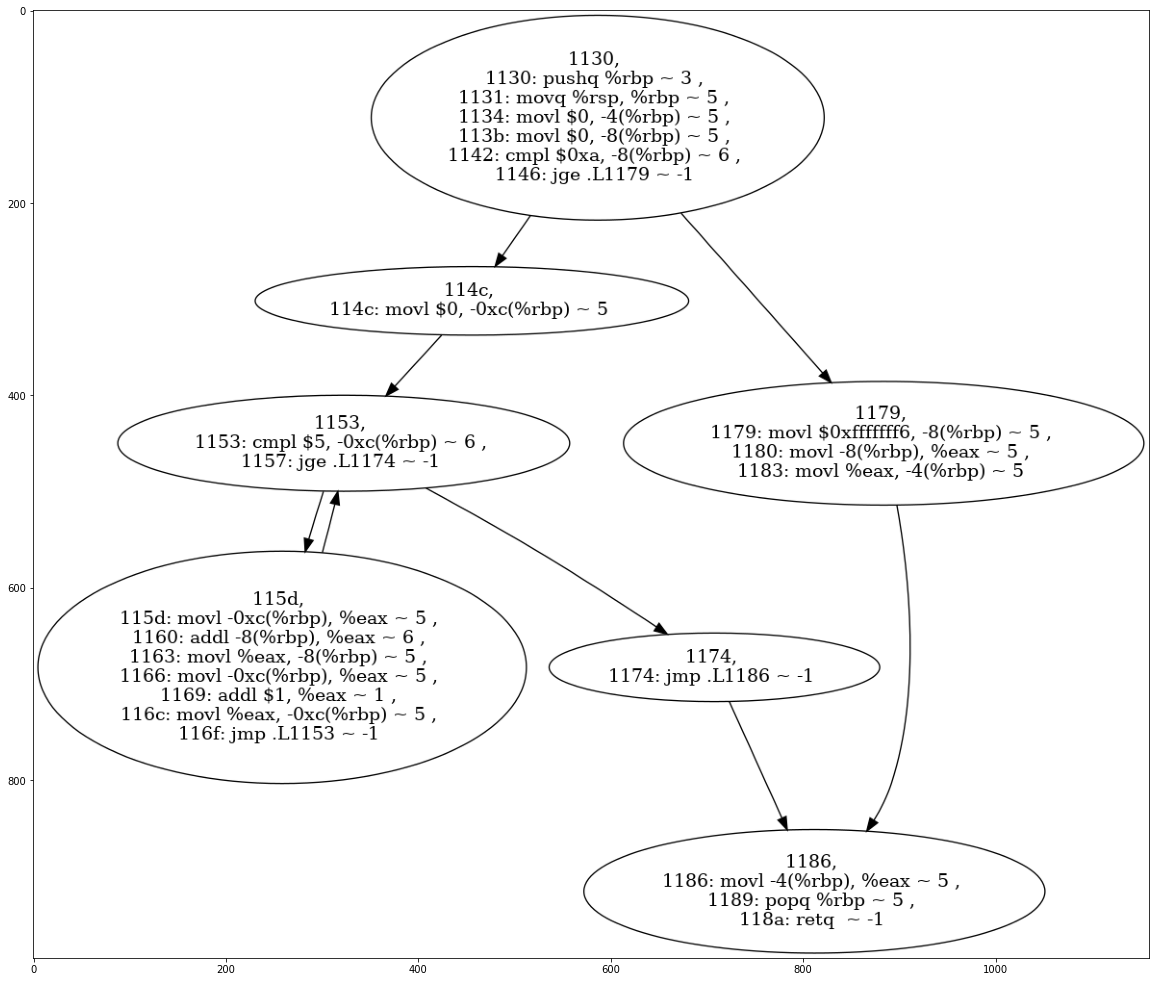

In [21]:
from rwtools.nemesis.nemesistool import NemesisInstrumentProgram
import subprocess 

tool = NemesisInstrumentProgram(input_binary, output_assembly)
figs, axs = plt.subplots(1, figsize=(20,20))
axs.imshow(tool.functions['main'].render_cfg())


# Alternative approach
First re-create loop structures, then apply the rest of the algorithm as before (without taking into account cycles) 

1. first detect which nodes belong to a cyce, depth of the cycle etc. (the body of the cycle?) 
2. determine where to insert this in the other branch 

Find a suitable edge, insert the entire loop there -- no existing node will be used as the loop body 
but I guess this is better since you cant always simply repeat a node without changing output and it is more simple 

What is the right edge to add the new structure? The edge at the same level as the start of the cycle 

OR 

let N be the target of the final jmp node of the cycle. If this N has a second parent (that is not the jump node) then insert the cycle between the parent and this target  (niet ideaal, dan zijn er al sowieso nodes die niet matchen met elkaar) Eigenlijk wil je de nieuwe movl en cmpl nodes op hetzelfde niveau als de bestaande (dan zijn die al sowieso gematcht) 

[*] Relocations for a section that's not loaded: .rela.dyn
[x] Could not replace value in .init_array
[x] Couldn't find valid section 3e20
[x] Couldn't find valid section 3fd8
[x] Couldn't find valid section 3fe0
[x] Couldn't find valid section 3fe8
[x] Couldn't find valid section 3ff0
[x] Couldn't find valid section 3ff8


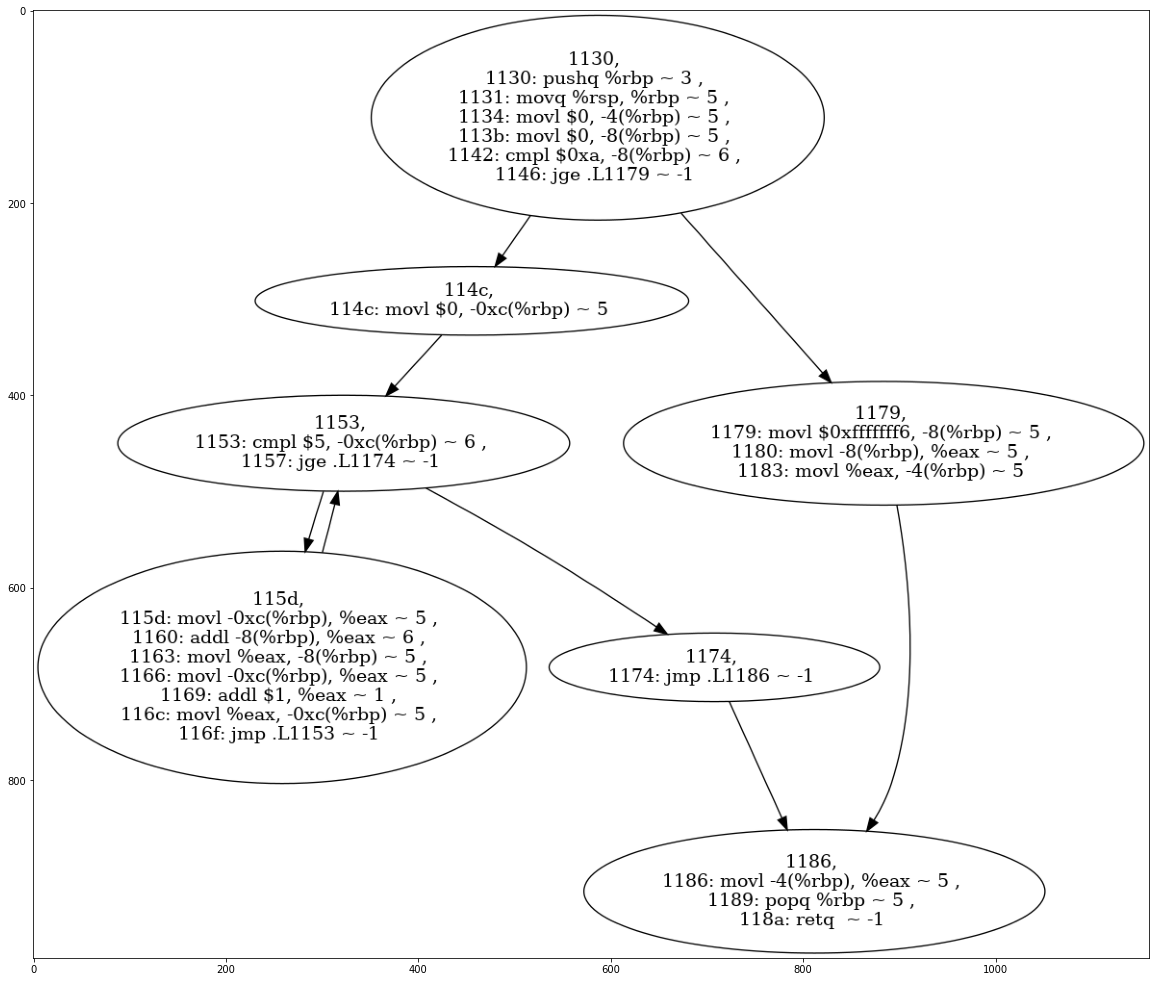

In [43]:
# from rwtools.nemesis.nemesistool import NemesisInstrument
from networkx.algorithms.cycles import simple_cycles 
from networkx.algorithms.dag import topological_sort 
from networkx.algorithms.shortest_paths.generic import shortest_path_length
from rwtools.nemesis.nemesistool import is_branch
from rwtools.nemesis.graph.nemesis_node import NemesisNode
import networkx as nx 
# figs, axs = plt.subplots(2, figsize=(20,20))


tool = NemesisInstrumentProgram(input_binary, output_assembly)

func = tool.functions['main']

binary = os.path.abspath("./for_loop/for_loop")
outputfile = "./for_loop.s"

figs, axs = plt.subplots(1, figsize=(20, 20))
axs.imshow(func.render_cfg())

In [44]:
def determine_induction_variable(node):
    jmp = node.instruction_wrappers[-1]
    cmp = node.instruction_wrappers[-2]

    assert is_branch(str(jmp))
    assert "cmpl" in str(cmp)

    final_val, variable = cmp.op_str.split(", ")
    return final_val, variable
    print(args)


def determine_start_value(node, variable):
    for wrapper in node.instruction_wrappers[::-1]:
        mnem = wrapper.mnemonic
        op_str = wrapper.op_str
        if variable in op_str:
            if True in [x in mnem for x in ['movl']]:
                initial_value, var = op_str.split(", ")
                assert var == variable
                return initial_value
    return None


In [60]:
from rwtools.nemesis.cycles import get_cycles_info 



tool = NemesisInstrumentProgram(input_binary, output_assembly)

func = tool.functions['main']

target_node = func.cfg.get_node('1130')
cfg = func.cfg 

##################
# start function #
##################

cycles = get_cycles_info(cfg, target_node)
for c in cycles: 
    for n in c['nodes']: 
        print(n.id)


[*] Relocations for a section that's not loaded: .rela.dyn
[x] Could not replace value in .init_array
[x] Couldn't find valid section 3e20
[x] Couldn't find valid section 3fd8
[x] Couldn't find valid section 3fe0
[x] Couldn't find valid section 3fe8
[x] Couldn't find valid section 3ff0
[x] Couldn't find valid section 3ff8
114c
1153
115d
1174


[*] Relocations for a section that's not loaded: .rela.dyn
[x] Could not replace value in .init_array
[x] Couldn't find valid section 3e20
[x] Couldn't find valid section 3fd8
[x] Couldn't find valid section 3fe0
[x] Couldn't find valid section 3fe8
[x] Couldn't find valid section 3ff0
[x] Couldn't find valid section 3ff8


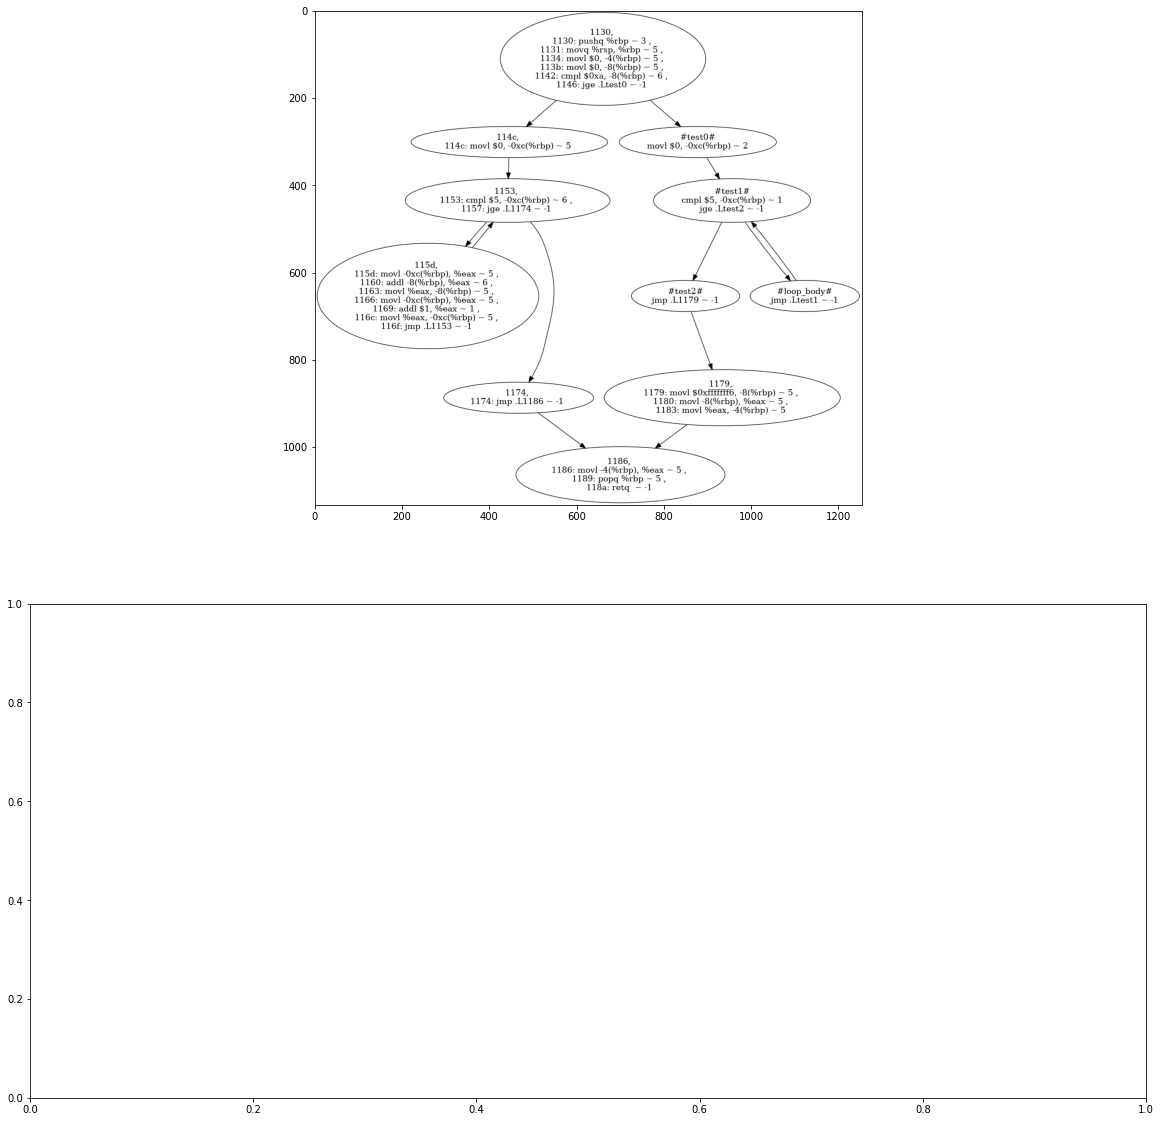

In [74]:

####################
# Find target edge #
####################

tool = NemesisInstrumentProgram(input_binary, output_assembly)

func = tool.functions['main']

target_node = func.cfg.get_node('1130')
cfg = func.cfg 


cycles = get_cycles_info(cfg, target_node)

target_cycle = cycles[0]
for node, depth in path_lengths.items():
    if depth == target_cycle['depths'][0]:
        if node in target_cycle['nodes']:
            continue
        else:
            # node is at the depth where a cycle should begin but there is no cycle present here 
            # insert (into the edge between this node and its parent) a structure equal to the branching node 
            new_cycle_nodes = [] 
            for i in range(max(target_cycle['depths']) - min(target_cycle['depths']) + 1 ):
                new_node = AbstractNemesisNode([], f'test{i}')
                func.cfg.insert_as_parent(new_node, node)
                new_cycle_nodes.append(new_node)

            # note, what you could is simply copy these statements over from the other nods
            # in the first node, add movl statement 
            new_cycle_nodes[0].insert(0, 'movl $0, -0xc(%rbp)', 2)
            
            # in the second node add cmpl and jge 
            new_cycle_nodes[1].insert(0, 'cmpl $5, -0xc(%rbp)', 1)
            new_cycle_nodes[1].insert(1, 'jge .Ltest2', -1)
            
            # add a second node 
            new_node = AbstractNemesisNode([], 'loop_body')
            new_node.insert(0, f'jmp {new_cycle_nodes[1].get_start_label()}', -1)
            
            func.cfg.graph.add_edge(new_node, new_cycle_nodes[1])
            func.cfg.graph.add_edge(new_cycle_nodes[1], new_node)
            
            new_cycle_nodes[-1].insert(0, f"jmp {node.get_start_label()}", -1)
            break 
    
figs, axs = plt.subplots(2, figsize=(20, 20))

axs[0].imshow(func.render_cfg())

# func.cfg.unwind_graph()
# func.cfg.insert_nodes(target_node)

# func.cfg.equalize_branches(target_node)


# func.cfg.restore_cycles()
# func.cfg.unwind_graph()

# func.align(target_node)
# func.cfg.insert_labels()
# axs[1].imshow(nemesis.render_cfg())

# # nemesis.cfg.insert_labels()
# func.cfg.merge_inserted_nodes()



# Attempt 1: 
First do inserting of nodes, and then rearrange nodes to get everything correct 
Problem: see CFG . 
You need to insert an additional lvel into the right branch as a parent of the leaf -- this means you also have to insert additional node in the left branch. This would mean you 
1) insert additional nodes  
2) rearrange nodes  
3) insert additional nodes again   

too messy 

[*] Relocations for a section that's not loaded: .rela.dyn
[x] Could not replace value in .init_array
[x] Couldn't find valid section 3e20
[x] Couldn't find valid section 3fd8
[x] Couldn't find valid section 3fe0
[x] Couldn't find valid section 3fe8
[x] Couldn't find valid section 3ff0
[x] Couldn't find valid section 3ff8
no latency information found for instruction: jge 
no latency information found for instruction: jge 
no latency information found for instruction: retq 
[1, 2, 3, 4]


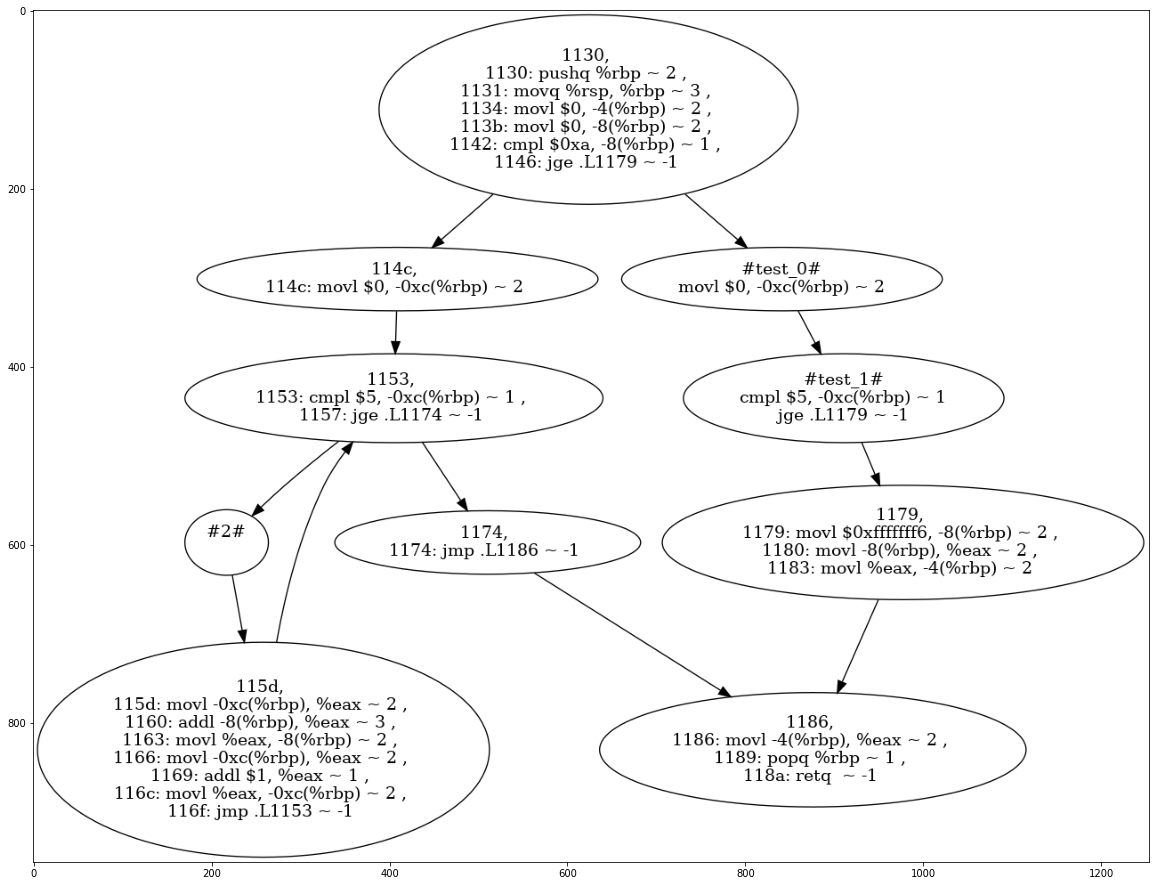

In [93]:
from rwtools.nemesis.nemesistool import NemesisInstrument
from networkx.algorithms.cycles import simple_cycles 
from networkx.algorithms.dag import topological_sort 
from networkx.algorithms.shortest_paths.generic import shortest_path_length
from rwtools.nemesis.nemesistool import is_branch
from rwtools.nemesis.graph.nemesis_node import NemesisNode
import networkx as nx 
# figs, axs = plt.subplots(2, figsize=(20,20))

binary = os.path.abspath("./for_loop/for_loop")
outputfile = "./for_loop.s"

nemesis = NemesisInstrument(binary, outputfile)

target_node = nemesis.cfg.get_node('1130')
cfg = nemesis.cfg 

##################
# start function #
##################

cfg.unwind_graph()
cfg.insert_nodes(target_node)
cfg.equalize_branches(target_node)
subgraph = cfg.subgraph(target_node)
cfg.restore_cycles()

path_lengths = shortest_path_length(G=cfg.graph, source=target_node)

def determine_induction_variable(node):
    jmp = node.instruction_wrappers[-1]
    cmp = node.instruction_wrappers[-2]
    
    assert is_branch(str(jmp))
    assert "cmpl" in str(cmp)
    
    final_val, variable = cmp.op_str.split(", ")
    return final_val, variable
    print(args)

def determine_start_value(node, variable):
    for wrapper in node.instruction_wrappers[::-1]:
        mnem = wrapper.mnemonic
        op_str = wrapper.op_str
        if variable in op_str:
            if True in [x in mnem for x in ['movl']]:
                initial_value, var = op_str.split(", ")
                assert var == variable
                return initial_value
    return None 
    
cycles = []    
for cycle in simple_cycles(subgraph): 
    cycle_info = {}
    cycle_nodes = sorted(cycle, key=lambda n : path_lengths[n])
    # also add successor of the first node -- contains initialization of induction register
    cycle_nodes.insert(0, next(cfg.graph.predecessors(cycle_nodes[0])))
    
    cycle_info['depths'] = [path_lengths[n] for n in cycle_nodes]
    
    # determine which register is used as induction register 
    # this is the register that is used in the cmpl statement right before the jmp in the second node
    
    cycle_info['nodes'] = cycle_nodes
    
    final_value, variable = determine_induction_variable(cycle_nodes[1])
    cycle_info['final_value'] = final_value
    cycle_info['variable'] = variable 
    
    start_value = determine_start_value(cycle_nodes[0], variable)
    cycle_info['start_value'] = start_value 
    cycles.append(cycle_info)

print(cycles[0]["depths"])


# if a cycle goes through levels d1, d2, d3, ..., dn then
# 1) all nodes at level d1 should initialize induction variable 

test_cycle = cycles[0]
node_depths = shortest_path_length(nemesis.cfg.graph, target_node)
initialize_depth = test_cycle['depths'][0]
cmpl_depth = test_cycle['depths'][1]
loop_body = test_cycle['depths'][2:]

def is_cmpl(node, cycle):
    # retrn true if the node is a cmpl node for the given cycle 
    var = cycle['variable']
    if isinstance(node, NemesisNode):
        instr = str(node.instruction_wrappers[-2])
        if "cmpl" in instr and var in instr:
            return True
    return False 
    
def is_initialize(node, cycle):
    # retrn true if the node is a cmpl node for the given cycle 
    var = cycle['variable']
    if isinstance(node, NemesisNode):
        instr = str(node.instruction_wrappers[-1])
        if "mov" in instr and var in instr:
            return True
    return False 

# all nodes at 'initialize_depth' shoulld be nodes that initialize the loop variable 
# if this does not hold for some node, insert initailize node as parent and remove some 
# abstract descendant 


for node in [node for node, depth in node_depths.items() if depth == initialize_depth]:
    if not is_initialize(node, test_cycle):
        # insert a new node that initialize the induction variable as a parent of the current node
        new_node = AbstractNemesisNode([], f"test_0")
        new_node.insert(0, "movl $0, -0xc(%rbp)", 2)
        nemesis.cfg.insert_as_parent(new_node, node)
        
        descendants = sorted(list(nx.descendants(nemesis.cfg.graph, node)), key=lambda n : node_depths[n])
        for n in desc:
            if not isinstance(n, NemesisNode) and nemesis.cfg.graph.in_degree(n) == 1:
                nemesis.cfg.remove_node(n)
                break 
                
node_depths = shortest_path_length(nemesis.cfg.graph, target_node)

    # do the same for cmpl node 
for node in [node for node, depth in node_depths.items() if depth == cmpl_depth]:
    if not is_cmpl(node, test_cycle):
        # insert a new node that initialize the induction variable as a parent of the current node
        new_node = AbstractNemesisNode([], f"test_1")
        
        new_node.insert(0, "cmpl $5, -0xc(%rbp)", 1)
        new_node.insert(1, "jge .L1179", -1)
        
        nemesis.cfg.insert_as_parent(new_node, node)
        
        descendants = sorted(list(nx.descendants(nemesis.cfg.graph, node)), key=lambda n : node_depths[n])
        for n in descendants:
            if not isinstance(n, NemesisNode) and nemesis.cfg.graph.in_degree(n) == 1:
                nemesis.cfg.remove_node(n)
                break 
                
                
# nemesis.align(target_node)
figs, axs = plt.subplots(1, figsize=(20, 20))

axs.imshow(nemesis.render_cfg())

# Can't merge this tree 
Can't merge inserted (abstract) nodes into descendants if there is a branch at some point where the parent and both children are abstract (see example above)

(of misschien is dit wel mogelijk, idk) 